# ESMAP

The [Energy Sector Management Assistance Program (ESMAP)](http://www.esmap.org/) is an energy assistance program administered by the World Bank. The program aims to support low- and middle-income countries to achieve environmentally sustainable energy solutions. This is achieved through numerous initiatives, which include renewable energy resource mapping.

Outcomes of the program include the [Global Solar Atlas](https://globalsolaratlas.info), a series of maps of annual irradiance covering the entire world.

Additionally, ESMAP has also commissioned several short-term in-situ measurement campaigns of irradiance in Africa and Asia. These campaigns include both Tier 1 and 2 stations and typically have a duration of 1-2 years. The data from these campaigns are freely available at https://energydata.info.


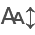

In [6]:
import pandas as pd
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

# Load stations
solarstations = pd.read_csv('../solarstations.csv', dtype={'Tier': str}).fillna('')
esmap_stations = pd.read_csv('../esmap_stations.csv', dtype={'Tier': str}).fillna('')
stations = pd.concat([solarstations, esmap_stations], axis='rows', ignore_index=True)

stations = stations[stations['Network'].str.contains('ESMAP')].reset_index()

In [17]:
import folium
from folium import plugins
import folium_legend

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[10, 45],
    zoom_start=3, min_zoom=1, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)

def station_status(time_period):
    if time_period.endswith('-'):
        return 'Active'
        color = '#008000'  # Green for active stations
    elif (time_period == '') | time_period.endswith('?'):
        return 'Unknown'
    else:
        return 'Inactive'

stations['Status'] = stations['Time period'].map(station_status)

status_dict = {
    'Active': '#008000',  # Green for active stations
    'Unknown': '#3186cc',  # Blue for stations with unknown status
    'Inactive': '#ff422b',  # Red for inactive stations
}

stations['Color'] = stations['Status'].map(status_dict)

# Add each station to the map
for index, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Station full name'] + ' - ' + str(row['State']) + ' ' + row['Country'],
        tooltip=row['Abbreviation'],
        radius=5, color=row['Color'],
        fill_color=row['Color'], fill=True).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution, show=False).add_to(m)
folium.LayerControl(position='topright').add_to(m)

# Additional options and plugins
# Note it's not possible to change the position of the scale
#plugins.MiniMap(toggle_display=True, zoom_level_fixed=3, minimized=True, position='bottomright').add_to(m)  # Add minimap to the map
plugins.Fullscreen(position='bottomright').add_to(m)  # Add full screen button to map
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map
# plugins.LocateControl(position='topright').add_to(m)  # Add button for your position
# plugins.MeasureControl(position='topleft').add_to(m)  # Add distance length measurement tool

# Create legend
legend = folium_legend.make_legend(status_dict.keys(), status_dict.values(), title="Station status")
m.get_root().html.add_child(legend)  # Add Legend to map

# Show the map
m